In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/2021/lesson6')

Mounted at /content/drive


## Modelling Correlation between Risks

* The estimate of default probabilities and their correlations is the most important issue in credit derivative valuation and credit risk management. 


* **Default correlation measures the tendency of two companies to default at about the same time**. For this there are two ways: 
  * *Historical default data* played an important role in the estimation of default probabilities, but: 
    * default events are rare so there is very limited default data available (we will face this issue when working with Neural Networks);
    * historical data reflects default patterns only and it may not be a proper indicator of the future default scenarios; hence default probabilities estimate from historical data is difficult and inexact and to estimate default correlations with same data is even more difficult and more inexact. 
  * *Mathematical models* don't rely on historical default data: is the way that is now used to estimate/apply correlations.

### Distribution Transformation

* Distribution transformation (also called *inverse transform*, *probability integral transform* or *percentile-to-percentile transform*) is used to transform a random variable PDF to a uniform distribution and vice versa. 
* The key ingredient of this method are:
  * computing the CDF or the quantile function of a distibution;
  * uniform samples can be interpreted as cumulative probabilities (i.e.  CDF$_{\textrm{uniform}}(X)=X$).
    
$$\textrm{uniform_sample} \rightarrow \tt{distribution.ppf(uniform\_sample)} \rightarrow \textrm{distribution_sample}$$
$$\textrm{distribution_sample} \rightarrow \tt{distribution.cdf(distribution\_sample)} \rightarrow \textrm{uniform_sample}$$
    
#### Example

* $U(X)$ is the uniform distribution: to convert to normal just apply the quantile function (the inverse of the CDF).

In [ ]:
# make table uniform to gauss
from scipy.stats import norm

U = [0.3, 0.5, 0.9, 0.999999999]

for x in U:
  print (x, norm.ppf(x))


0.3 -0.5244005127080409
0.5 0.0
0.9 1.2815515655446004
0.999999999 5.997807019601637


<img src="https://drive.google.com/uc?id=1KVtr2VG_l2jVcfJ6C8Nw6ChSMYyKCo3d" width=600>

* $\tt{python}$ provides an easier way to apply such transformations:
  * Given a distribution class (e.g. uniform, norm,...):
      * $\tt{rvs}$ method samples $\tt{size}$ times from it.
      * methods like $\tt{cdf}$ or $\tt{ppf}$ take in input $\tt{numpy.array}$, a particular kind of list, allowing to avoid loop-cycles:
        * the method itself is indeed automatically applied to each item of the array.

In [ ]:
# sample from uniform adnd transform to norm
from scipy.stats import uniform, norm

x_unif = uniform.rvs(size=10000)
x = norm.ppf(x_unif)

<img src="https://drive.google.com/uc?id=1hI__fhnbuRSIfghtaq7oxlJuopcVlLqp">

* with a 2D plot we can get a sense of what is going on when using the inverse CDF transformation:

<img src="https://drive.google.com/uc?id=1iGVVqrrPZ_Ag1Kg_PysJzRM0Z5F0MOSp">

* It stretches the outer regions of the uniform to yield a normal distribution. 


* This technique can be used with any arbitrary (univariate) probability distributions, like for example t-Student or Gumbel.

In [ ]:
# do the same with t-student
from scipy.stats import t

x2 = t(4).ppf(x_unif)

<img src="https://drive.google.com/uc?id=1bvn2OmnZz3iLzpq4jQMHqn_aLgRLiSCI">

* To go from an arbitray distribution to uniform, just apply the inverse of the inverse CDF, which is the CDF itself...

In [ ]:
# make uniform to gauss to uniform

x2 = norm.ppf(x_unif)
x3 = norm.cdf(x2)

print (x3[0:5])
print (x_unif[0:5])

[0.68578219 0.18308334 0.4033235  0.6605622  0.90699742]
[0.68578219 0.18308334 0.4033235  0.6605622  0.90699742]


<img src="https://drive.google.com/uc?id=1oOhLIBIkYdM7qWVek9yHLlgJofo0snnX">

* This particular $\tt{python}$ notation is called *slicing* of an array
    

* Imagine to have a 2D matrix: to access an element of the matrix it is necessary to specify two indices (the row and the column of the element)

In [ ]:
import numpy as np

a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
print (a)
print("")
print (a[2, 2])

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]

11


* To access a range of values it is possible to specify the interval of indices inside square brackets

In [ ]:
print (a[1, 1:3])

[6 7]


* Finally to get an entire row (or column) it is enough to specify $\tt{:}$ (colon) as index

In [ ]:
print (a[1, :]) 
print ("")
print (a[1, 0:4]) # which is equivalent

[5 6 7 8]

[5 6 7 8]


## Copula

* Copulas are used to describe dependencies between random variables and widely used in quantitative finance to model risk. 

* In probability theory a *copula* $\mathcal{C}(F_1, F_2, \ldots, F_n)$ is a multivariate cumulative distribution function whose marginal probability distributions (the probability distribution of each dimension) are uniform. 
        
* Very popular since allow to easily model and estimate the distribution of random vectors by representing marginals and their correlation separately such that **a complicated problem can be split into simpler components**.

### Example

* Look at various rivers and for each one look at its maximum water level, and also count how many times each river caused flooding.
    * maximum level of the river distributed as *Gumbel*;
    * number of floods modelled according to a *Beta* distribution.

* **It's reasonable to assume that the two are correlated**.
* Since it was only specified the distributions of the individual variables, we don't know how we could model the joint correlated probability distribution. 

* **Copulas** allow to decompose a joint probability distribution into their marginals (which by definition have no correlation) and a function which couples them together (hence the name).

#### Modelling Correlation with Copulas

* All the ingredients are already available:
  1. Sample from a multivariate normal (2D) with a 0.5 correlation.
    * The covariance between random variables can be expressed with the matrix:
$$
\Sigma = \begin{bmatrix}
\sigma^2 (X_0) & \mathrm{Cov}(X_0, X_1) & \mathrm{Cov}(X_0, X_2)\\
 \mathrm{Cov}(X_1, X_0) & \sigma^2 (X_1) & \mathrm{Cov}(X_1, X_2)\\
 \mathrm{Cov}(X_2, X_0) & \mathrm{Cov}(X_2, X_1) & \sigma^2 (X_2)\\
\end{bmatrix}
$$

In [ ]:
# sample from multi-normal with corr
from scipy.stats import multivariate_normal

mv = multivariate_normal(mean=[0, 0], cov=[[1, 0.5], [0.5, 1]])
x = mv.rvs(size=10000)

print (x[0:5, :])

[[ 0.11020096  0.27288312]
 [-0.58581765 -1.54168931]
 [ 0.71249361 -0.36075703]
 [-1.14900536 -0.93650629]
 [ 0.26670755  0.28289569]]


In [ ]:
import plotly.graph_objects as go
import numpy as np

x, y = (np.arange(-4, 4, .01), np.arange(-4, 4, .01))
z = np.loadtxt('https://raw.githubusercontent.com/matteosan1/finance_course/develop/libro/input_files/multivariate_normal_corr.csv', delimiter=',')

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='Multivariate Normal w/ correlation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [ ]:
z = np.loadtxt('https://raw.githubusercontent.com/matteosan1/finance_course/develop/libro/input_files/multivariate_normal_uncorr.csv', delimiter=',')

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='Multivariate Normal w/o correlation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

<img src="https://drive.google.com/uc?id=1gRecEC4t1ZoqppVneea3DDEJbaa9xdmC">

* Now tranform the marginals to uniform using the $\tt{cdf}$ method. 

In [ ]:
# convert each component
from scipy.stats import norm

x_unif = norm.cdf(x)

In [ ]:
print (x_unif)

[[0.543875   0.60752847]
 [0.27899903 0.06157456]
 [0.76192042 0.35914054]
 ...
 [0.99725061 0.93212657]
 [0.51870472 0.89214691]
 [0.31107138 0.82970797]]


<table>
    <tr>
        <td><img src="https://drive.google.com/uc?id=1gjR0tfDGUx20Edz7XcV3ViArW6Yr-Bvq" width=500></td>
        <td><img src="https://drive.google.com/uc?id=1ATeUMB9p2tjJoqLplxddnB-K4XUJ3xIm" width=500></td>
    </tr>
</table>

* These plots are usually how copulas are visualized. 


* **Since we used a multivariate stadard normal to model correlation this is also called a Gaussian Copula.**
  * Gaussian copula is nice and easy to construct but tends to underestimate events on the tails.
  * In reality, within the financial markets, tail events occur much more
frequently. So it is often used the **t-Student copula** which has fatter tails but preserves the same (bell shaped, non-skewed) characteristics of the Gaussian.

<table>
    <tr>
        <td><img src="https://drive.google.com/uc?id=1rARyDX0KFcLJ5riOmzGMFSJ7mW9TqG_K" width=500></td>
        <td><img src="https://drive.google.com/uc?id=1kXN1ulCocg_JxIVBOec0gf61WHtcg90O" width=500></td>
    </tr>
</table>

* Finally we can just transform the marginals from uniform to what we want (i.e. Gumbel and Beta in our river example): 

In [ ]:
# convert again to gumbel e beta(a=4, b=10)
from scipy.stats import gumbel_l, beta

gumbel = gumbel_l()
beta = beta(a=4, b=10)
x1 = gumbel.ppf(x_unif[:, 0])
x2 = beta.ppf(x_unif[:, 1])

* Just compare the scatter plot with correlation to the joint distribution of the same marginals without.

In [ ]:
# sample from Gumbel
# sample from Beta

x1_uncorr = gumbel.rvs(size=10000)
x2_uncorr = beta.rvs(size=10000)

<table>
    <tr>
        <td><img src="https://drive.google.com/uc?id=1kT7LvV598cB3SjiFxrPxY-3ulhr3wazG" width=500></td>
        <td><img src="https://drive.google.com/uc?id=1VTtw38XbdJfkLeN1ImaLgmeoV5tVnEcE" width=500></td>
    </tr>
</table>

* Clearly this is directly extendeable to higher dimensional distributions as well.

In [ ]:
# events without correlation

n = 0
for i in range(len(x1_uncorr)):
  if 0 < x1_uncorr[i] < 2 and 0.3 < x2_uncorr[i] < 0.4:
    n += 1
print (n/len(x_unif))

0.093


In [ ]:
# events with correlation
llim_g = gumbel.cdf(0)
ulim_g = gumbel.cdf(2)

llim_b = beta.cdf(0.3)
ulim_b = beta.cdf(0.4)

n = 0
for u in x_unif:
  if llim_g < u[0] < ulim_g and llim_b < u[1] < ulim_b:
    n += 1
print (n/len(x_unif))

0.1237


<img src="https://drive.google.com/uc?id=1PTxL9-JDa18sKfTdq39ZhsaWBLvU9AAW" width=500>

* In this case the fraction of events in the same range is around 10.2%

### How to Simulate a Default

* Imagine a company with 20\% probability of defaulting within the next year.

* To simulate credit events it can be thrown a random number from the uniform distribution between 0 and 1:
  * if it is lower or equal to 0.2 then there has been default;
  * if it is higher no default happened.

* In such a way we have a "successful" experiment with the desired probability (20\% in the example).

In [ ]:
from random import seed, random

seed(1)
Pd = 0.2
sims = 10000
successes = 0
for _ in range(sims):
  x = random()
  if x <= Pd:
    successes += 1

print (successes/sims)

0.2058



### Generate Correlated Distributions (Numerical Example)

* Imagine three companies (A, B and C) with cumulative 2 years default probability $P_d$ of 10%.
* Compute the probability to have the three of them all defaulting within the next two years: 
  * with independent $P_d$;
  * with fully correlated $P_d$.

#### Independent probabilities
* In this case the odds to get three defaults within two years is the product of the single probabilities, hence:

$$P_d^{\mathrm{uncorr}}= 10\%\cdot 10\%\cdot 10\% = 0.1\%$$
 

In [ ]:
# test default probabilities of three companies (no corr)
from scipy.stats import multivariate_normal, norm

seed(1)
sims = 100000
successes = 0
mv = multivariate_normal(mean=[0, 0, 0], cov=[[1, 0, 0], [0, 1, 0], [0, 0, 1]])
v = norm.cdf(mv.rvs(size=sims))

for x in v:
  if max(x) <= 0.1:
    successes += 1

print (successes/sims)

0.00097


* Repeat the same Monte Carlo experiment with perfectly correlated default probabilities:

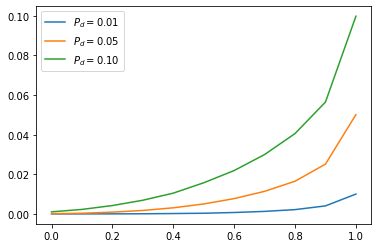

In [ ]:
# test default probabilities of three companies (perfect corr)
from scipy.stats import multivariate_normal, norm
from numpy.random import seed
import numpy as np
from matplotlib import pyplot as plt

seed(1)
sims = 1000000
res = []
Pds = [0.01, 0.05, 0.1]
for Pd in Pds:
  temp = []
  for rho in np.arange(0, 1.1, 0.1):
    if rho == 1.0:
      rho = 0.999999999
  
    mv = multivariate_normal(mean=[0, 0, 0], cov=[[1, rho, rho], 
                                                  [rho, 1, rho], 
                                                  [rho, rho, 1]])
    v = norm.cdf(mv.rvs(size=sims))
    successes = (v.max(axis=1)<Pd).sum()
    # this is a more concise and faster code for
    # for x in v:
    #     if max(v) < Pd:
    #          successes += 1
    temp.append(successes/sims)
  res.append(temp)

for i, r in enumerate(res):
  plt.plot(np.arange(0, 1.1, 0.1), r, label=r'$P_d=${:.2f}'.format(Pds[i]))
plt.legend()
plt.show()

* In this case the result is close to 10%.
    * Indeed being the three companies perfectly correlated either there is no default or three *simultaneous* defaults with 10% probability.

## Gaussian Copula Model (Analytical Solution)

* The first copulla model introduced was the *one-factor Gaussian*.
    * This model has, above all, the advantage that can be solved analytically.


* Consider a portfolio of $N$ bonds with known marginal probabilities of default
    * $t_i$, the time of default of the $i^{th}$ company;
    * $Q_i(t)$, the cumulative probability that company $i$ will default before time $t$; that is, the probability that $t_i \le t$.

* To generate a one-factor model for the $t_i$ we define random variables 

$$X_i = a_i M + \sqrt{1-a_i^2}Z_i,\qquad i = 1, 2,\ldots, N$$

* where $M$ and the $Z_i$ are independent zero-mean unit-variance distributions (hence $X_i$ are also distributed with zero-mean and unit standard-deviation) and $-1 \le a_i \lt 1$.
    * Previous equation defines a correlation structure between the $X_i$ which depends on a single common factor $M$;
    * $Z_i$ terms are usually called the *idiosyncratic* component of default.
* In the simplest approach $M$ and $Z$ are normal distributions, hence the name **one-factor Gaussian copula model**. Also the pairwise default correlations are the same, i.e $a_i = a$; in other words the contribution of the market 	component $M$ is the same for all the companies.
  * One factor because there is only a random variable, $M$, which determines the correlation between $X_i$.

* With a percentile to percentile transformation we can map the $X_i$ to the $t_i$ (default times) so that:

$$
\mathcal{Q}_i(t_i|M) = \Phi\left(\cfrac{\Phi^{-1}[Q_i(t_i)]-a M}{\sqrt{1-a^2}}\right)
$$

* where $\Phi$ denotes the standard normal CDF. 


* If $\mathcal{C}(t_1,\ldots,t_N)$ is the joint distribution of the default times of the $N$ bonds in the portfolio then

$$
\mathcal{C}(t_1,\ldots,t_N)=\Phi_{A}(\Phi^{-1}(Q_1(t_1)),\ldots,\Phi^{-1}(Q_N(t_N)))
$$

* where $A$ is the correlation matrix of the default probabilities, is the one factor Gaussian copula.
    
* Different distributions result in different copula models, and in different natures of the default dependence. 
    * For example, copulas where the \(M\) have heavy tails generate models where there is a greater likelihood of a clustering of early defaults for several companies.


## Binomial Distribution

* The binomial distribution represents the discrete probability of independent events and each event has exactly two possible outcomes (e.g. toss of a coin).


* The binomial distribution answers to the question: what is the probability of exactly $k$ successes on $n$ repeated trials given that:
    * the number of observations or trials is fixed;
    * each observation or trial is independent (e.g. like in the coin toss, the previous toss doesn’t affect the following);
    * the probability of success is exactly the same from one trial to another (e.g. each coin toss has 50% chances to fall in heads or tails).

$$\mathrm{PMF_{binomial}} = \binom{n}{k} p^{k}(1-p)^{n-k} = \cfrac{n!}{k!(n−k)!} p^{k}(1-p)^{n-k}$$

In [ ]:
# heads probability of tossing a coin 10 times
from scipy.stats import binom

b = binom(10, 0.5)
print (b.pmf(5))

0.24609375000000025


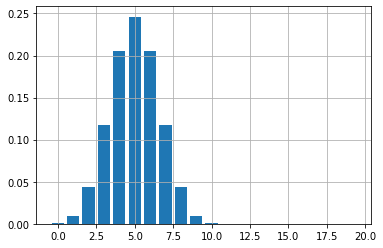

In [ ]:
from matplotlib import pyplot as plt

x = range(20)
plt.bar(x, binom(10, 0.5).pmf(x))
plt.grid(True)
plt.show()

In [ ]:
# compute as difference of cdfs or 1-cdf
print (b.cdf(10)-b.cdf(4))
print (1-b.cdf(4))

0.6230468749999999
0.6230468749999999


#### Back to Gaussian Copula Model
* Given the market situation $M = m$, all the companies have the same cumulative default probability $\mathcal{Q}_i(t_i|m)=P(X_i \le x|m)$.

* If $l_{t|m}$ is the total defaults that have occurred by time $t$, then it follows a binomial distribution (each default has the same probability and events are independent to each other once $M$ is fixed)

$$\mathcal{Q}(l_{t|m} = j) = \cfrac{N!}{j!(N-j)!}Q^j_{t|m}(1-Q_{t|m})^{N-j},\qquad  j=0, 1, 2,\ldots,N$$

* To evaluate any function of the correlated default probability $g(\mathcal{Q}(l_t))$, regardless the value of $M$ is necessary to average 

$$
g(\mathcal{Q}(l_{t} = j)) = \int_{-\infty}^{\infty}{g(\mathcal{Q}(l_{t|m} = j))\cdot f_M(m)dm}
$$

* where $f_M(m)$ is the PDF of $M$.

## Basket Default Swaps
* A basket default swap (BDS) is a credit derivative on a portfolio of reference entities. 
    * The simplest basket default swaps are first-to-default, second-to-default...nth-to-default swaps. 


* Very similar to normal CDS except for the protection they offer:
    * a first-to-default swap provides insurance for only the first default happening;
    * a second-to-default swap provides insurance for only the second default...
    

* For example, in a nth-to-default swap, the seller does not make any payment to the protection buyer for the first $n-1$ defaulted entities, and makes it only for the
$n^{th}$ default. Once there has been this payment the swap terminates.


### n$^{th}$-to-default Basket Valuation 

* Assume the principals and expected recovery rates are the same for all underlying reference assets.
* Also all the assets have the same default probability.


* The valuation procedure is similar to that for a regular CDS:
    * in CDS depends on $P_d$ of the reference asset between times $t_1$ and $t_2$. 
    * in BDS depends on $P_d$ that the $n^{th}$ asset default was between times $t_1$ and $t_2$.

* The buyer of protection makes quarterly payments at a specified rate until the $n^{th}$ default occurs or the end of the life of the contract is reached. 


* In the event of the $n^{th}$ default occurring, the seller pays $F\cdot(1-R)$.


* compute the correlated default probability of each name according to 

$$\mathcal{Q}(t|M) = \Phi\left(\cfrac{\Phi^{-1}[Q(t)]-\sqrt{\rho} M}{\sqrt{1-\rho}}\right)$$

* compute the probability to have at least j defaults using the binomial distribution

$$\mathcal{Q}(l_{t|m} \ge j) = \sum_{k=j}^{N}\left[\cfrac{N!}{k!(N-k)!}\mathcal{Q}(t|M)^k(1-\mathcal{Q}(t|M))^{N-k}\right]$$

* create a **credit curve**, $CC(\mathcal{Q})$, with those probabilities;
* re-use the $\tt{CreditDefaultSwap}$ class methods to compute NPV (which depends on a discount curve and the previous credit curve), through integration of

$$ \mathrm{NPV}_{BDS}(D_{curve}, C_{curve}(\mathcal{Q})) = \int_{-\infty}^{\infty}{\mathrm{NPV}_{CDS}(D_{curve}, C_{curve}(\mathcal{Q})|M) f_M(m)dm} $$

### $\tt{args}$ and $\tt{kwargs}$

* $\tt{args}$ and $\tt{kwargs}$ represent two useful ways of passing parameters to a function that is called by another function.

In [ ]:
a=1
b=1
c=5

def runner(f, x):
  return f(x)*2

def func(x):
  return a*x**2 + b*x + c

# run 'runner' for 3 values of a in x=2
print (runner(func, 2))

30


In [ ]:
def runner(f, x, args):
    return f(x, *args)*2
    
def func(x, a, b, c):
    return a*x**2 + b*x + c

for v in range(3):
    print (runner(func, 2, args=(v, 1, 5)))

14
22
30


* $\tt{kwargs}$ works like $\tt{args}$ except that you have to pass a dictionary with as keys the names of the parameters. Also to expand it you have to use the double-star operator.

In [ ]:
def runner(f, x, kwargs):
    return f(x, **kwargs)*2

def func(x, a, b, c):
    return a*x**2 + b*x + c

for v in range(3):
    print (runner(func, 2, kwargs={"a":v, "c":5, "b":1}))

14
22
30


#### Integration in Python

* To integrate a function $f$ in $\tt{python}$ we can use the $\tt{scipy.integrate.quad}$ which takes as input:
    * the function to integrate; 
    * the integration limits;
    * optional arguments of the integrand.

$$f(x) = \int_{-2}^{4}(ax^{3} + b)~dx$$

* for $a=3$ and $b=5$. 

$$\int_{-2}^{4}(ax^{3} + b)~dx = a\cfrac{x^4}{4} + bx \Bigg\rvert_{-2}^{4} = 210$$

In [ ]:
from scipy.integrate import quad

def func(x, a, b):
    return a*x**3 + b

s = quad(func, -2, 4, args=(3, 5))
print (s)

(210.0, 2.475694446663456e-12)


In [ ]:
from finmarkets import CreditCurve, CreditDefaultSwap
from scipy.stats import norm, binom
from numpy import sqrt, exp
from scipy.integrate import quad
import numpy as np

class BasketDefaultSwap:
  def __init__(self, nominal, N_names, rho, start_date, spread, maturity, tenor=3, recovery=0.4):
    self.cds = CreditDefaultSwap(nominal, start_date, spread, maturity, tenor, recovery)
    self.N_names = N_names
    self.rho = rho

  def npv(self, Q_dates, Q, dc, n_defaults):
    v = quad(self.one_factor_model, -np.inf, np.inf,
             args=(self.cds.npv, Q_dates, Q, dc, n_defaults))
    return v[0]

  def one_factor_model(self, M, f, dates, Q, dc, n_defaults):
    Q_corr = norm.cdf((norm.ppf(Q)-sqrt(self.rho*M))/sqrt(1-self.rho))
    b = binom(self.N_names, Q_corr)
    S = b.cdf(n_defaults-1) 
    cc = CreditCurve(dates, S)
    return f(dc, cc)*norm.pdf(M)

* Consider a 5-year 3rd-to-default CDS on a basket of 10 reference entities with copula correlation of 0.3 and the expected recovery rate, $R$, is $40\%$. 


* The term structure of interest rates is assumed to be flat at 5%. 


* The default probabilities for the 10 entities are generated by Poisson processes with constant default intensities, $\lambda_i = 0.01$, so that 

$$Q(t) = 1 - e^{-\lambda t} $$

In [ ]:
from finmarkets import DiscountCurve
from datetime import date
from dateutil.relativedelta import relativedelta
import numpy as np

n_cds = 10
l = 0.01
pricing_date = date.today()
pillar_dates = [pricing_date + relativedelta(years=i) for i in range(6)]
dfs = [1/(1+0.05)**i for i in range(6)]
dc = DiscountCurve(pillar_dates, dfs)
Q = [1-np.exp(-(l*t)) for t in range(6)]

y = []
for n_defaults in range(1, 10):
  x = []
  tempy = []
  for rho in np.arange(0., 1.1, 0.1):
    basket = BasketDefaultSwap(1e6, n_cds, rho, pricing_date, 0.01, 5)
    npv = basket.npv(pillar_dates, Q, dc, ndefaults))
    tempy.append(npv)
  y.append(tempy)

<img src="https://drive.google.com/uc?id=1YerqEIw5MHrtf6kyLWxwFEmm8lep3eWg">